In [ ]:
# Using Reddit's API for Predicting Comments
# What characteristics of a post on Reddit contribute most to what subreddit it belongs to?
# In this project, we will practice two major skills.

# Collecting data via an API request.
# Building a binary predictor.
# Your method for acquiring the data will be scraping threads from at least two subreddits.

# Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts which subreddit a given post belongs to.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [ ]:
# Pre-work. Demonstrate scraping Thread Info from Reddit.com
# Set up a request (using requests) to the URL below.
# *NOTE*: Reddit will throw a [429 error](https://httpstatuses.com/429) when using the following code:

# res = requests.get(URL)
# This is because Reddit has throttled python's default user agent. You'll need to set a custom User-agent to get your request to work.

# res = requests.get(URL, headers={'User-agent': 'YOUR NAME Bot 0.1'})

In [ ]:
# For example:
# pre_work = False
# if pre_work:
#     url = "http://www.reddit.com/r/boardgames.json"
#     headers = headers={'User-agent': 'gbkgwyneth Bot 0.1'}
#     res = requests.get(url, headers=headers)
#     res.status_code

In [ ]:
# Use res.json() to convert the response into a dictionary format and set this to a variable.
# data = res.json()

In [ ]:
# if pre_work:
#     data = res.json()

#     # Some initial exploring of the data
#     ['data', 'kind']
#     sorted(data.keys())

#     ['after', 'before', 'children', 'dist', 'modhash']
#     sorted(data['data'].keys())

#     df = pd.DataFrame(data['data']['children'])
#     df.head()
#     df.shape
#     [post['data']['name'] for post in data['data']['children']]

In [ ]:
# Getting more results
# By default, Reddit will give you the top 25 posts:

# print(len(data['data']['children']))
# If you want more, you'll need to do two things:

# Get the name of the last post: data['data']['after']
# Use that name to hit the following url: http://www.reddit.com/r/boardgames.json?after=THE_AFTER_FROM_STEP_1`
# Create a loop to repeat steps 1 and 2 until you have a sufficient number of posts.
# *NOTE*: Reddit will limit the number of requests per second you're allowed to make. When you create your loop, be sure to add the following after each iteration.

# time.sleep(3) # sleeps 3 seconds before continuing
# This will throttle your loop and keep you within Reddit's guidelines. You'll need to import the time library for this to work!

In [ ]:
# I. Predicting posts from the Cape Cod and Galveston sub-Reddits
# With no experience of Reddit, I had a challenge underatnding how it worked, what people discuss, and what types of "topics" would be interesting to predict. I settled on predicting posts from the r/CapeCod versus the r/galveston. If I were to start-over, I would definitely try to find more interesting topics, but I am not sure that I have yet spent enough time with Reddit to be able to pedict what those might be.

In [ ]:
# I. Gather the raw data from Reddit.
# Save the scraped data as two CSV files or read previously scraped data from CSV files into two DataFrame.

In [ ]:
# Function to scrape the data 

# def scrape_data(url,after):

#     headers = headers={'User-agent': 'Gauss Markov'}

#     posts = []
#     for _ in range(40):
#         if after == None:
#             params = {}
#         else:
#             params = {'after' : after}
#         res = requests.get(url, params=params, headers=headers)
#         if res.status_code == 200:
#             data = res.json()
#             posts.extend(data['data']['children'])
#             after = data['data']['after']
# #             print(after)
#         else:
#             warning(f'Status Code {res.status_code}')
#             break
        
#         time.sleep(3)
#     success(f'Scraping complete {url}')
#     return posts

In [ ]:
# Scrape posts following 'after' from the first URL 
# Place them in a dataframe
# Export to a file

# def scrape (topic_1, topic_2,check):
#     if check == True: 
#         after = None
#         url_1 = "https://www.reddit.com/r/"+topic_1+".json"
#         note(f'Scraping {url_1}')
#         scrape_1 = scrape_data(url_1, after)
#         posts_1 = []
#         for i in range(len(scrape_1)):
#             posts_1.append(scrape_1[i]['data'])
#         df_1 = pd.DataFrame(posts_1)
#         df_1.drop_duplicates(subset='title', inplace=True)
#         df_1.to_csv(f'../data/{topic_1}.csv')

#         after = None
#         url_2 = "https://www.reddit.com/r/"+topic_2+".json"
#         note(f'Scraping {url_2}')
#         scrape_2 = scrape_data(url_2, after)
#         posts_2 = []
#         for i in range(len(scrape_2)):
#             posts_2.append(scrape_2[i]['data'])
#         df_2 = pd.DataFrame(posts_2)
#         df_2.drop_duplicates(subset='title', inplace=True)
#         df_2.to_csv(f'../data/{topic_2}.csv')

In [ ]:
# scrape('worldnews','conspiracy',False)

In [ ]:
# Scrape posts following 'after' from the second URL 
# Place them in a dataframe
# Export to a file

# if scrape:
#     after = None # "t3_35fh6e"
#     url_cape = "https://www.reddit.com/r/Economics.json"
#     scrape_cape  = scrape_data(url_cape,after)

#     posts_cape = []
#     for i in range(len(scrape_cape)):
#         posts_cape.append(scrape_cape[i]['data'])
#     df_cape = pd.DataFrame(posts_cape)
#     df_cape.drop_duplicates(subset='title', inplace=True)
#     df_cape.to_csv(f'../data/economics.csv')

In [ ]:
# If not scraping, read from csv
# if not scrape:
# df_news = pd.read_csv("../data/worldnews.csv")
# df_fake = pd.read_csv("../data/conspiracy.csv")

In [ ]:
# III. Explore the data.
# Use CountVectorizer or TfidfVectorizer from scikit-learn to create features from the thread titles and descriptions (NOTE: Not all threads have a description).

# Create the DataFrame and the target vector
# Where y=1, the post is from r/CapeCod.

In [ ]:
# # Create the target vector 
# df_news['is_fake'] = 0
# df_fake['is_fake'] = 1

# # Merge the datafrmaes
# df = df_news.append(df_fake, sort=True)
# df = df[['is_fake', 'title','id']]
# df.set_index("id", inplace=True)

# # Split the target vector from the dataframe
# y = df['is_fake']
# df.drop('is_fake', inplace=True, axis=1)
# df.head()

In [ ]:
# View the word clouds
# The WordCloud is from Peekaboo.

In [ ]:
# From https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python

# remove = ['let','says','will','new','one','day','shut']
# stopwords = remove + list(STOPWORDS)
# # mask = np.array(Image.open("../images/text.png"))
# colors = theme
# cmap = LinearSegmentedColormap.from_list("mycmap", colors)
# def show_wordcloud(data, title = None):
#     wordcloud = WordCloud(
#         background_color='white',
#         stopwords=stopwords,
#         max_words=50,
#         max_font_size=100,
#         scale=3,
#         random_state=1, # chosen at random by flipping a coin; it was heads
#         colormap=cmap,
# #         mask=mask
#     ).generate(str(data))

#     fig = plt.figure(1, figsize=(16, 9))
#     plt.axis('off')
#     if title:
#         fig.suptitle(title, fontsize=20)
#         fig.subplots_adjust(top=2.3)

#     plt.imshow(wordcloud)
#     plt.show()

In [ ]:
# show_wordcloud(df_news['title'])

In [ ]:
# show_wordcloud(df_fake['title'])

In [ ]:
# Why Python and others
# df_gv[df_gv['title'].str.contains("Texas")]
# df_cape[df_cape['title'].str.contains("Texas")]

In [ ]:
# Train/Test split
# X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42, stratify=y)

In [ ]:
# Run a simple CountVectorizer and explore.

In [ ]:
# cv_simple = CountVectorizer(stop_words=stopwords)
# X_train_cv = cv_simple.fit_transform(X_train['title'])

# cv_train = pd.DataFrame(X_train_cv.todense(), columns=cv_simple.get_feature_names())

In [ ]:
# Create a dataframe with counts of most common words

In [ ]:
# Create a data frame of the most common words 

# n_words = 20
# words = list(cv_train.sum().sort_values(ascending=False)[:n_words].index)
# cv_train['is_fake'] = y_train.values
# cv_train_small = cv_train.groupby('is_fake').sum()[words]
# cv_train_small.head()

In [ ]:
# Plot the most common words

In [ ]:
# Adapted from https://matplotlib.org/examples/api/barchart_demo.html

# words_fake = words
# words_count_fake = cv_train_small.loc[1]
# words_gv = words
# words_count_news = cv_train_small.loc[0]
# width = 0.35       # the width of the bars
# ind = np.arange(n_words)

# fig, ax = plt.subplots(figsize=(16, 9))
# rects1 = ax.bar(ind, words_count_fake, width, color=theme[0])
# rects2 = ax.bar(ind+width,words_count_news, width, color=theme[-1])

# # add some text for labels, title and axes ticks
# ax.set_ylabel('Counts')
# ax.set_title('Counts by word and reddit')
# ax.set_xticks(ind + width / 2)
# ax.set_xticklabels(words,rotation='vertical')

# ax.set_ylim(0,80)

# ax.legend((rects1[0], rects2[0]), ('Fake News', 'World News'))

# plt.show()

In [ ]:
# The most common words are not very surprising - place names.

# Since the beach in Galveston faces southeast, 'sunset' is a Cape Cod term. And Galveston has floating casinos, thus 'gaming'.

In [ ]:
# Run a simple TfidfVectorizer and explore.

In [ ]:
# tv_simple = TfidfVectorizer(stop_words=stopwords)
# X_train_tv = tv_simple.fit_transform(X_train['title'])

# tv_train = pd.DataFrame(X_train_tv.todense(), columns=tv_simple.get_feature_names())
# tv_train.head()

In [ ]:
# Create a dataframe with counts of most frequent words

In [ ]:
# Create a data frame of the most common words 

# n_words = 20
# words = list(tv_train.sum().sort_values(ascending=False)[:n_words].index)
# tv_train['is_fake'] = y_train.values
# tv_train_small = tv_train.groupby('is_fake').sum()[words]
# tv_train_small.head()

In [ ]:
# Plot the most frequent words

In [ ]:
# Adapted from https://matplotlib.org/examples/api/barchart_demo.html

# words_fake = words
# words_count_fake = tv_train_small.loc[1]
# words_news = words
# words_count_news = tv_train_small.loc[0]
# width = 0.35       # the width of the bars
# ind = np.arange(n_words)

# fig, ax = plt.subplots(figsize=(16, 9))
# rects1 = ax.barh(ind, words_count_fake, width, color=colors[0])
# rects2 = ax.barh(ind+width,words_count_news, width, color=colors[-1])

# # add some text for labels, title and axes ticks
# ax.set_xlabel('TF-IDF value')
# ax.set_title('TF-IDF by word and reddit')
# ax.set_yticks(ind + width / 2)
# ax.set_yticklabels(words)  #,rotation='vertical')

# ax.set_xlim(0,20)

# ax.legend((rects1[0], rects2[0]), ('Fake News', 'World News'))

# plt.show()

In [ ]:
# From looking at the most frequent words, I think that without place names, it will be difficult to differentiate between the two sets of posts. But we'll give it the good old college try.

In [ ]:
# IV. Natural Language Processing (NLP)
# Use CountVectorizer or TfidfVectorizer from scikit-learn to create features from the thread titles and descriptions (NOTE: Not all threads have a description).
# Examine using count or binary features in the model
# Re-evaluate your models using these. Does this improve the model performance?
# What text features are the most valuable?
# As a first step to get a baseline, use a simple CountVectorizer and model with with regression.

In [ ]:
# Basic CountVectorizer and LogisticRegression to get a simple first model

# cv_simple = CountVectorizer(stop_words=stopwords)
# X_train_cv = cv_simple.fit_transform(X_train['title'])
# X_test_cv = cv_simple.transform(X_test['title'])

# print("There are {} features in the model.".format(len(cv_simple.get_feature_names())))

# lr_simple = LogisticRegressionCV(cv=3)
# lr_simple.fit(X_train_cv, y_train)
# score_train = lr_simple.score(X_train_cv, y_train)
# score_test = lr_simple.score(X_test_cv, y_test)

# # There are 3440 features in the model.
# # Train score: 0.9695740365111561 Test score 0.8157894736842105
# print("Train score: {} Test score {}".format(score_train, score_test))

In [ ]:
# The model seems to be quite overfit. If I could, I would gather more data.

In [ ]:
# # What are the words that best predict the target based on the coefficients

# coef_names = cv_simple.get_feature_names()

# coef_df = pd.DataFrame ({
#     'coefs' : coef_names,
#     'vals' : lr_simple.coef_[0]
# }).set_index('coefs')

# coef_df.reindex(coef_df['vals'].abs().sort_values(ascending=False).index)[:20].T

In [ ]:
# The model appears to be overfit since the "training score" is much highter than the "testing score". Again, the words with the largest coefficients are mostly unsurprising.
# Galveston is an island and has a seawall.
# I do wonder why "water" has such a large coefficient.
# The word "hole" makes me think of "Woods hole", so I'll try bi-grams as well.

In [ ]:
# Second step: add in bi-grams, use a simple CountVectorizer, and model with with regression.

In [ ]:
# cv_gram = CountVectorizer(ngram_range=(1,2))
# X_train_cvg = cv_gram.fit_transform(X_train['title'])
# X_test_cvg = cv_gram.transform(X_test['title'])

# print("There are {} features in the model.".format(len(cv_gram.get_feature_names())))

# lr_simple = LogisticRegressionCV(cv=3)
# lr_simple.fit(X_train_cvg, y_train)
# score_train = lr_simple.score(X_train_cvg, y_train)
# score_test = lr_simple.score(X_test_cvg, y_test)

# # There are 11975 features in the model.
# # Train score: 0.9959432048681541 Test score 0.8218623481781376
# print("Train score: {} Test score {}".format(score_train, score_test))

In [ ]:
# The training score is much higher, but the test score is not much higher... And the mode is still overfit.

In [ ]:
# What is the baseline accuracy for this model?

In [ ]:
# print("The baseline accuracy for this model is {:.2f}%.".format(
#     cross_val_score(lr_simple, X_train_cvg, y_train).mean()*100))

In [ ]:
# Run a CountVectorizer and regression adding in a pipeline and grid search. Also, eliminate the stop words.

In [ ]:
# # Create the pipeline
# pipe_cv = Pipeline([
#     ('cv', CountVectorizer()),
#     ('lr', LogisticRegression()),
# ])

# params_grid_cv = {
#     'cv__stop_words' : [stopwords],
#     'cv__ngram_range' : [(1,1), (1,2)],
#     'cv__max_df' : [1.0, 0.95],
#     'cv__min_df' : [1, 2],
#     'cv__max_features' : [2000, 2250, 2500],
#     'lr__C' : [1, .05],
#     'lr__penalty' : ['l1', 'l2']
# }

# # Grid Search!
# gs_cv = GridSearchCV(pipe_cv, param_grid=params_grid_cv, verbose=1)

# gs_cv.fit(X_train['title'], y_train)
# score_train = gs_cv.best_score_
# score_test = gs_cv.score(X_test['title'], y_test)
# params_train = gs_cv.best_params_

# for k in params_grid_cv:
#     print("{}: {}".format(k,params_train[k]))

# print("Train score: {} Test score {}".format(score_train, score_test))

# # Fitting 3 folds for each of 192 candidates, totalling 576 fits
# # cv__stop_words: english
# # cv__ngram_range: (1, 2)
# # cv__max_df: 1.0
# # cv__min_df: 1
# # cv__max_features: 2250
# # lr__C: 1
# # lr__penalty: l2
# # Train score: 0.8079783637592968 Test score 0.8178137651821862

In [ ]:
# Take a look at the coefficients in the model to see which words best predict the target

In [ ]:
# # What are the words that best predict the target?

# coef_names = gs_cv.best_estimator_.named_steps['cv'].get_feature_names()
# coef_vals = gs_cv.best_estimator_.named_steps['lr'].coef_[0]

# coef_df = pd.DataFrame ({
#     'coefs' : coef_names,
#     'vals' : coef_vals
# }).set_index('coefs')

# coef_df.reindex(coef_df['vals'].abs().sort_values(ascending=False).index)[:20].T

In [ ]:
# Create a function to run grid search on anything we might want to investigate.
# This could be generalized further, I'm sure, but for now it is enough.

In [ ]:
# def create_pipline(items, use_params, X_train, X_test, y_train, y_test):

#     # Add a pipe, add a param !
#     pipe_items = {
#         'cv': CountVectorizer(stop_words = stopwords),
#         'tv': TfidfVectorizer(stop_words = stopwords),
#         'hv': HashingVectorizer(stop_words = stopwords),

#         'ss' : StandardScaler(),
#         'pf' : PolynomialFeatures(),

#         'lr' : LogisticRegression(),
#         'bnb' : BernoulliNB(),
#         'mnb' : MultinomialNB(),
#         'rf' : RandomForestClassifier(),
#         'gb' : GradientBoostingClassifier(),
#         'ab' : AdaBoostClassifier(),
#         'svc' : SVC(),
#         'knn' : KNeighborsClassifier()
#     }

#     # Include at least one param for each pipe item
#     param_items = {
#         'cv' : {
#             'cv__ngram_range' : [(1,1), (1,2)],
#             'cv__max_df' : [1.0, 0.95],
#             'cv__min_df' : [1],
#             'cv__max_features' : [2000, 2250, 2500, 2750]
#         },
#         'tv' : {
#             'tv__ngram_range' : [(1,1), (1,2)],
#             'tv__max_df' : [1.0, 0.95],
#             'tv__min_df' : [1, 2],
#             'tv__max_features' : [2000, 2250, 2500, 2750]
#         },
#         'hv' : {
#             'hv__ngram_range' : [(1,1), (1,2)]
#         },
#         'ss' : {
#             'ss__with_mean' : [False]
#         },
#         'pf' : {
#             'pf__degree' : [2]
#         },
#         'lr' : {
#             'lr__C' : [1, .05],
#             'lr__penalty' : ['l2']
#         },
#         'bnb' : {
#             'bnb__alpha' : [1.0, 1.5, 1.8, 2.0]
#         },
#         'mnb' : {
#             'mnb__alpha' : [0.8, 1.0, 1.2]
#         },
#         'rf' : {
#             'rf__n_estimators' : [8, 10, 15]
#         },
#         'gb' : {
#             'gb__n_estimators' : [80, 100, 120]
#         },
#         'ab' : {
#             'ab__n_estimators' : [75, 50, 125]
#         },
#         'svc' : {
#             'svc__kernel' : ['linear','poly']
#         },
#         'knn' : {
#             'knn__n_neighbors' : [25,35,45]
#         }
#     }

#     # Create the parameters for GridSearch
#     params = dict()
#     if use_params:
#         for i in items:
#             for p in param_items[i]:
#                 params[p] = param_items[i][p]

#     # Create the pipeline
#     pipe_list = [(i,pipe_items[i]) for i in items]
#     print("Using:")
#     for p in pipe_list:
#         print("\t" + str(p[1]).split('(')[0])
#     pipe = Pipeline(pipe_list)

#     # Grid search
#     gs = GridSearchCV(pipe, param_grid=params, verbose=1)
#     gs.fit(X_train, y_train)

#     # Print the results
#     train_params = gs.best_params_
#     train_score = gs.best_score_
#     y_test_hat = gs.predict(X_test)
#     test_score = gs.score(X_test, y_test)

#     for k in train_params:
#         print("{}: {}".format(k,train_params[k]))

#     print("Train score: {} Test score {}".format(train_score, test_score))
#     print("")

#     return train_score, test_score, y_test_hat, train_params


In [ ]:
# Choose some vectorizers and models to test.
# This runs a long time!
# TI ran this many times, updating the parameters to tune

In [ ]:
# #Decide what to put into the pipline, grid searh, and save the "best" for each grid search
# use_params = True
# vects = ['cv','tv','hv']
# models = ['lr','bnb', 'mnb','rf','gb','ab','svc','knn']
# other = ['pf','ss']

# # After some initial tests, these seem like the best to pursue further
# vects = ['cv','tv']
# models = ['lr','bnb', 'mnb']
# other = []

# model_solns = {}
# idx = 0
# for v in vects:
#     for i in range(len(other)+1):
#         for o in list(combinations(other, i)):
#             for m in models:
#                 idx += 1
#                 pipe_items = [v]
#                 pipe_items.extend(list(o))
#                 pipe_items.append(m)
#                 [train_score, test_score, y_test_hat, best_params] = create_pipline(pipe_items, use_params,
#                                                                         X_train['title'], X_test['title'],
#                                                                         y_train, y_test)
#                 model_solns[idx] = {'vectorizer' : v, 'model': m, 'features': list(o),
#                                     'train_score': train_score, 'test_score': test_score,
#                                     'best_params': best_params, 'y_test_hat' : y_test_hat}


In [ ]:
# Lots of results to examine. Unfortunately, none are exactly great. This is unsurprising given the two subreddits that I chose

In [ ]:
# V. Evaluate the model

In [ ]:
# Examine the best solutions from each call to the grid search

In [ ]:
# df_solns = pd.DataFrame(model_solns)
# df_solns.sort_values(ascending=False, by='test_score',axis=1)

In [ ]:
# df_solns.loc[['vectorizer','model','train_score','test_score','best_params'],:]

In [ ]:
# Closely look at the parameters and see if we hit an boundary on our parameter options

In [ ]:
# df_solns.loc[:,3]

In [ ]:
# Let's look at the parameters of one solution
# df_solns.loc['best_params',3]

In [ ]:
# Can get a better value by averaging our top models?

In [ ]:
# # Average the y_test_hat vectors to see if we can improve the score
# y_test_hat_agg = sum(df_solns.loc['y_test_hat',:])
# y_test_hat = np.round(y_test_hat_agg/df_solns.shape[1])
# print("The accuracy score of the average test solutions is {:.2f}%.".format(accuracy_score(y_test,y_test_hat)*100))

In [ ]:
# This aggregated solution is actually a little better

In [ ]:
# What are some of the "misses"?

In [ ]:
# # Not sure why I get warnings when adding these
# X_test['y'] = y_test.values
# X_test['y_hat'] = y_test_hat
# X_test['y_hat_agg'] = y_test_hat_agg

In [ ]:
# Remember, where y=1, the post is from r/CapeCod

In [ ]:
# X_test_incorrect = X_test[X_test["y"] != X_test['y_hat']]
# X_test_incorrect.head(20)

In [ ]:
# With more data, I think some of these could be mode accurately predicted. For example:

# "Marstons Mills" is a town on Cape Cod.
# Fertitta is a chef in Galveston.
# But some are generic and likely could never be determined:
# Dog friendly restaurants?
# Batting cages???

In [ ]:
# cv_simple = CountVectorizer(stop_words='english')
# X_test_cv = cv_simple.fit_transform(X_test_incorrect['title'])
# cv_test = pd.DataFrame(X_test_cv.todense(), columns=cv_simple.get_feature_names())

In [ ]:
# # Create a data frame of the most common words 
# n_words = 40
# words = list(cv_test.sum().sort_values(ascending=False)[:n_words].index)
# print(words)

# cv_test['is_fake_test'] = X_test_incorrect['y'].values
# cv_test_small = cv_test.groupby('is_fake_test').sum()[words]

In [ ]:
# columns = [c for c in cv_test_small.columns if c in cv_train.columns]
# cv_train = cv_train[columns]
# cv_train['is_fake'] = y_train.values
# cv_train_small = cv_train.groupby('is_fake').sum()

# columns = [c for c in cv_train.columns if c in cv_test_small.columns]
# cv_test_small = cv_test_small[columns]

# cv_merge = pd.concat([cv_train_small, cv_test_small],keys=['train', 'incorrect'], sort=True)
# cv_merge.head()


In [ ]:
# # Adapted from https://matplotlib.org/examples/api/barchart_demo.html

# words = cv_merge.columns
# n_words = len(words)
# words_count_fake_train = cv_merge.loc["train"].loc[0]
# words_count_news_train = cv_merge.loc["train"].loc[1]
# words_count_fake_wrong = cv_merge.loc["incorrect"].loc[0]
# words_count_news_wrong = cv_merge.loc["incorrect"].loc[1]

# width = 0.25       # the width of the bars
# ind = np.arange(n_words)

# fig, ax = plt.subplots(figsize=(15, 10))
# rects0 = ax.bar(ind,         words_count_fake_train, width, color=colors[0])
# rects1 = ax.bar(ind+width,   words_count_fake_wrong, width, color=colors[2])
# rects2 = ax.bar(ind+2*width, words_count_news_train, width, color=colors[3])
# rects3 = ax.bar(ind+3*width, words_count_news_wrong, width, color=colors[-1])

# # add some text for labels, title and axes ticks
# ax.set_ylabel('Counts')
# ax.set_title('Counts by word and reddit')
# ax.set_xticks(ind + width / 2)
# ax.set_xticklabels(words,rotation='vertical')

# ax.set_ylim(0,80)

# ax.legend((rects0, rects1, rects2, rects3), ('Fake News Train', 'Fake News Incorrect',
#                                                          'World News', 'World News Incorrect'));


In [ ]:
# This plot did not come out as well as I had hoped, but I think I can improve on it in the future

In [ ]:
# VI. Executive summary
# The data
# For this project, I chose two sub-reddits to compare, r/Cape Cod and r/galveston. As this was my first experience with Reddit, I had some challenege to come up with two forums to compare since most anything I chose did not have enough posts. With more experience with Reddit, I might have been able to chose more interesting topics to compare. Scraping was easy enough, but since the Reddits are not extremely active, I did not end up with as much data as I would have liked

# Exploring the data
# Once I had scraped the data, I ran a number of initial tests on it to get some insight. I used a word cloud to illustrate the word used most often in each subreddit. I then ran a vectorizer on unigrams and made some bar charts comparing the usage of the most words. The results were not particularly surprising, though there were some words I had not anticipated such as 'seawall' and 'gaming'.

# Modeling the problem
# From there, I dove into NLP. I ran a few simple tests, determined a baseline accuracy, and examined the coefficients determied by logistical regression. Again, the words with the most influence were not surprising - mostly place names or things unique to one place or the other. Actually, there was one word with a aurprisingly high coefficient - 'water'.

# Evaluate the model
# I then spent some time trying to generalize pipelines in order to efficiently run lots of different grid searches on many different models and parameters. This generalized function has room for improvement, but was quite helpful for me to stay organized in my tests. I saved the "best" from each test and turned the data into a dataframe in order to explore the incorrect predictions.

# Despite tuning the parameters, I could not get better than 83% accuracy, unfortunately.

In [1]:
import requests
import json
import time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
from itertools import combinations
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display, Markdown, Latex
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap

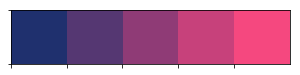

In [3]:
# Colour scheme and style selected
theme = ['#1F306E', '#553772', '#8F3B76', '#C7417B', '#F5487F']
colors_palette = sns.palplot(sns.color_palette(theme))
plt.style.use('seaborn')
sns.set(style="white", color_codes=True)
sns.set_palette(colors_palette)

# Prevent warnings from distracting the reader
warnings.filterwarnings('ignore')

# Forces Matplotlib to use high-quality images
ip = get_ipython()
ibe = ip.configurables[-1]
ibe.figure_formats = {'pdf', 'png'}

matplotlib.rcParams['figure.figsize'] = (16.0, 9.0)

In [4]:
def success (n):
    return display(Markdown(f'<div class="alert alert-block alert-success"><b>SUCCESS: </b>{n}</div>'))

In [5]:
def warning (n):
    return display(Markdown(f'<div class="alert alert-block alert-danger"><b>WARNING: </b>{n}</div>'))

In [6]:
def check (n):
    return display(Markdown(f'<div class="alert alert-block alert-warning"><b>CHECK: </b>{n}</div>'))

In [7]:
def note (n):
    return display(Markdown(f'<div class="alert alert-block alert-info"><b>NOTE: </b>{n}</div>'))    

In [8]:
# Function to scrape the data 

def scrape_data(url,after):

    headers = headers={'User-agent': 'Gauss Markov'}

    posts = []
    for _ in range(40):
        if after == None:
            params = {}
        else:
            params = {'after' : after}
        res = requests.get(url, params=params, headers=headers)
        if res.status_code == 200:
            data = res.json()
            posts.extend(data['data']['children'])
            after = data['data']['after']

        else:
            warning(f'Status Code {res.status_code}')
            break
        
        time.sleep(3)
    success(f'Scraping complete {url}')
    return posts

In [9]:
# Scrape posts following 'after' from the first URL 
# Place them in a dataframe
# Export to a file

def fake (topic_1, topic_2, topic_3, topic_4, check):
    if check == True: 
        after = None
        url_1 = "https://www.reddit.com/r/"+topic_1+".json"
        note(f'Scraping {url_1}')
        scrape_1 = scrape_data(url_1, after)
        posts = []
        for i in range(len(scrape_1)):
            posts.append(scrape_1[i]['data'])

        after = None
        url_2 = "https://www.reddit.com/r/"+topic_2+".json"
        note(f'Scraping {url_2}')
        scrape_2 = scrape_data(url_2, after)
        for i in range(len(scrape_2)):
            posts.append(scrape_2[i]['data'])
        
        after = None
        url_3 = "https://www.reddit.com/r/"+topic_3+".json"
        note(f'Scraping {url_3}')
        scrape_3 = scrape_data(url_3, after)
        for i in range(len(scrape_3)):
            posts.append(scrape_3[i]['data'])
        
        after = None
        url_4 = "https://www.reddit.com/r/"+topic_4+".json"
        note(f'Scraping {url_4}')
        scrape_4 = scrape_data(url_4, after)
        for i in range(len(scrape_4)):
            posts.append(scrape_4[i]['data'])
        df = pd.DataFrame(posts)
        df.drop_duplicates(subset='title', inplace=True)
        df.to_csv(f'../data/fake.csv')
        return df

In [10]:
# Scrape posts following 'after' from the first URL 
# Place them in a dataframe
# Export to a file

def news (topic_1, topic_2, topic_3, topic_4, check):
    if check == True: 
        after = None
        url_1 = "https://www.reddit.com/r/"+topic_1+".json"
        note(f'Scraping {url_1}')
        scrape_1 = scrape_data(url_1, after)
        posts = []
        for i in range(len(scrape_1)):
            posts.append(scrape_1[i]['data'])

        after = None
        url_2 = "https://www.reddit.com/r/"+topic_2+".json"
        note(f'Scraping {url_2}')
        scrape_2 = scrape_data(url_2, after)
        for i in range(len(scrape_2)):
            posts.append(scrape_2[i]['data'])
        
        after = None
        url_3 = "https://www.reddit.com/r/"+topic_3+".json"
        note(f'Scraping {url_3}')
        scrape_3 = scrape_data(url_3, after)
        for i in range(len(scrape_3)):
            posts.append(scrape_3[i]['data'])
        
        after = None
        url_4 = "https://www.reddit.com/r/"+topic_4+".json"
        note(f'Scraping {url_4}')
        scrape_4 = scrape_data(url_4, after)
        for i in range(len(scrape_4)):
            posts.append(scrape_4[i]['data'])
        df = pd.DataFrame(posts)
        df.drop_duplicates(subset='title', inplace=True)
        df.to_csv(f'../data/news.csv')
        return df

In [11]:
# df_fake = fake('conspiracy','fakenews','SFWdeepfakes','Fake',False)

In [12]:
# df_news = news('worldnews','news','worldpolitics','world',False)

In [48]:
df_fake = pd.read_csv('../data/fake.csv')

In [49]:
df_news = pd.read_csv('../data/news.csv')

In [50]:
def merge (df_1,df_2):
    # Create the target vector 
    df_1['is_fake'] = 0
    df_2['is_fake'] = 1

    # Merge the datafrmaes
    df = df_1.append(df_2, sort=True)
    df = df[['is_fake', 'title','id']]
    df.set_index("id", inplace=True)
    return df
    # Split the target vector from the dataframe

In [51]:
df = merge(df_news,df_fake)

In [52]:
y = df['is_fake']
df.drop('is_fake', inplace=True, axis=1)

In [31]:
stop_identifying = ['fake','real','deepfake','deepfakes','amp']
stop_transition_similar = ['in the first place','not only','but also','as a matter of fact','in like manner','in addition','coupled with','in the same fashion','in the same way','first','second','third','in the light of','not to mention','to say nothing of','equally important','by the same token','again','to','and','also','then','equally','identically','uniquely','like','as','too','moreover','as well as','together with','of course','likewise','comparatively','correspondingly','similarly','furthermore','additionally']
stop_transition_contradict = ['although this may be true','in contrast','different from','of course','but','on the other hand','on the contrary','at the same time','in spite of','even so','even though','be that as it may','then again','above all','in reality','after all','but','still','unlike','or','yet','while','albeit','besides','as much as','even though','although','instead','whereas','despite','conversely','otherwise','however','rather','nevertheless','nonetheless','regardless','notwithstanding']
stop_transition_condition = ['in the event that','granted that','so long as','as long as' 'on condition','on the condition that','for the purpose of','with this intention','with this in mind','in the hope that','to the end that','for fear that','in order to','seeing / being that','in view of','if','then','unless','when','whenever','while','because of','as','since','while','lest','in case','provided that','given that','only if','even if','so that','so as to','owing to','inasmuch as','due to']
stop_transition_emphasis = ['in other words','to put it differently','for one thing','as an illustration','in this case','for this reason','to put it another way','that is to say','with attention to','by all means','important to realize','another key point','first thing to remember','most compelling evidence','must be remembered','point often overlooked','to point out','on the positive side','on the negative side','with this in mind','notably','including','like','to be sure','namely','chiefly','truly','indeed','certainly','surely','markedly','such as','especially','explicitly','specifically','expressly','surprisingly','frequently','significantly','particularly','in fact','in general','in particular','in detail','for example','for instance','to demonstrate','to emphasize','to repeat','to clarify','to explain','to enumerate']
stop_transition_effect = ['as a result','under those circumstances','in that case','for this reason','in effect','for','thus','because the','then','hence','consequently','therefore','thereupon','forthwith','accordingly','henceforth']
stop_trasition_conclusion = ['as can be seen','generally speaking','in the final analysis','all things considered','as shown above','in the long run','given these points','as has been noted','in a word','for the most part','after all','in fact','in summary','in conclusion','in short','in brief','in essence','to summarize','on balance','altogether','overall','ordinarily','usually','by and large','to sum up','on the whole','in any event','in either case','all in all','obviously','ultimately','definitely']
stop_transition_time = ['at the present time','from time to time','sooner or later','at the same time','up to the present time','to begin with','in due time','as soon as','as long as','in the meantime','in a moment','without delay','in the first place','all of a sudden','at this instant','first','second','immediately','quickly','finally','after','later','last','until','till','since','then','before','hence','since','when','once','about','next','now','formerly','suddenly','shortly','henceforth','whenever','eventually','meanwhile','further','during','in time','prior to','forthwith','straightaway','by the time','whenever','until now','now that','instantly','presently','occasionally']
stop_transition_place = ['in the middle','to the left/right','in front of','on this side','in the distance','here and there','in the foreground','in the background','in the center of','adjacent to','opposite to','here','there','next','where','from','over','near','above','below','down','up','under','further','beyond','nearby','wherever','around','between','before','alongside','amid','among','beneath','beside','behind','across']
stop_transition = stop_transition_similar + stop_transition_contradict + stop_transition_condition + stop_transition_emphasis + stop_transition_effect + stop_trasition_conclusion + stop_transition_time + stop_transition_place
stop_conjunction = ['for','and','nor','but','or','yet','so','though','although','even though','while','if','only if','unless','until','provided that','assuming that','even if','','in case that','in case','lest','than','rather than','whether','as much as','whereas','after','as long as','as soon as','before','by the time','now that','once','since','till','until','when','whenever','while','because','since','so that','in order that','in order','why','that','what','whatever','which','whichever','who','whoever','whom','whomever','whose','how','as though','as if','where','wherever','as','just as','both','hardly','scarcely','so','when','and','either','or','neither','nor','if','then','not','but','what with','whether','or','not only','also','no sooner','rather','than','also','besides','furthermore','likewise','moreover','however','nevertheless','nonetheless','still','conversely','instead','otherwise','rather','accordingly','consequently','hence','meanwhile','then','therefore','thus']
stop_prepositions = ['on','in','at','since','until','till','for','ago','during','before','after','to','past','from','by','in','at','on','off','by','beside','under','over','below','above','up','down','across','through','to','into','out of','onto ',' towards',' from','of','by','about','for','with']
stopwords = stop_identifying + stop_transition + stop_conjunction + stop_prepositions + list(STOPWORDS)

In [22]:
# From https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python

# remove = ['fake','real','deepfake','deepfakes']#['let','says','will','new','one','day','shut','amp','fake','asks','help','first','now','time','years','two','don','man']
# stopwords = remove + list(STOPWORDS)
# mask = np.array(Image.open("../images/text.png"))
# colors = theme
# cmap = LinearSegmentedColormap.from_list("mycmap", colors)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=100,
        scale=3,
        random_state=1, # chosen at random by flipping a coin; it was heads
        colormap=LinearSegmentedColormap.from_list("mycmap", theme),
#         mask=mask
    ).generate(str(data))

    fig = plt.figure(1, figsize=(16, 9))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [30]:
df_news.title

0       Disaster is unfolding in Syria as videos emerg...
1       Washington is an 'absolute mess' under Trump, ...
2       Two young candidates running for Hong Kong Dis...
3       Scientists endorse mass civil disobedience to ...
4       US Military says Turkey's incursion into Syria...
5       'Americans sold us out,' Kurds guarding US bas...
6       Female Kurdish politician ‘executed’ by pro-Tu...
7       More than 500 million bees were found dead in ...
8       Kurds and President Assad sign deal to allow S...
9       Protesters erect 'Lady Liberty' statue on Hong...
10      US troops believe Turkey deliberately fired ar...
11      China’s social credit system shows its teeth, ...
12      Turkey ‘bombs convoy of foreign journalists an...
13      Chancellor Angela Merkel tells President Erdoğ...
14      Rape victims still being subjected to degradin...
15      Russia ‘bombed four hospitals in Syria in four...
16      Kurdish WWII veterans: Trump wasn’t born when ...
17      Retire

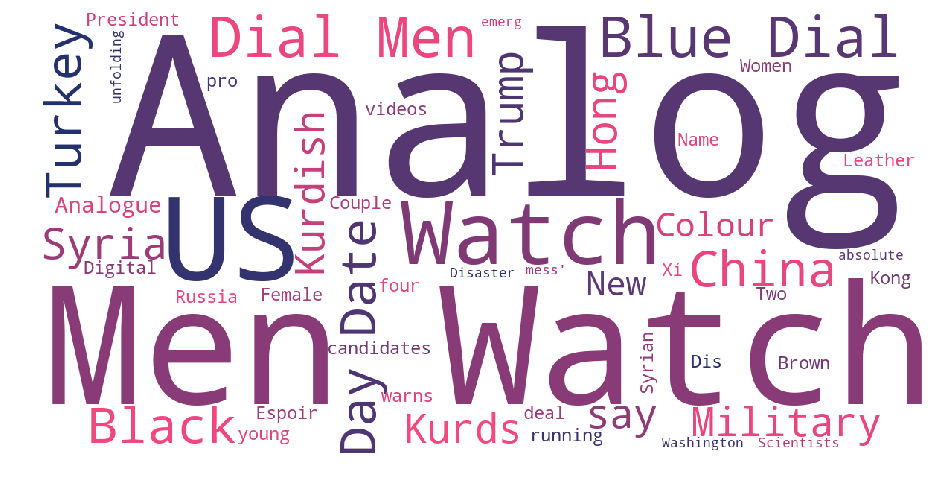

In [23]:
show_wordcloud(df_news['title'])

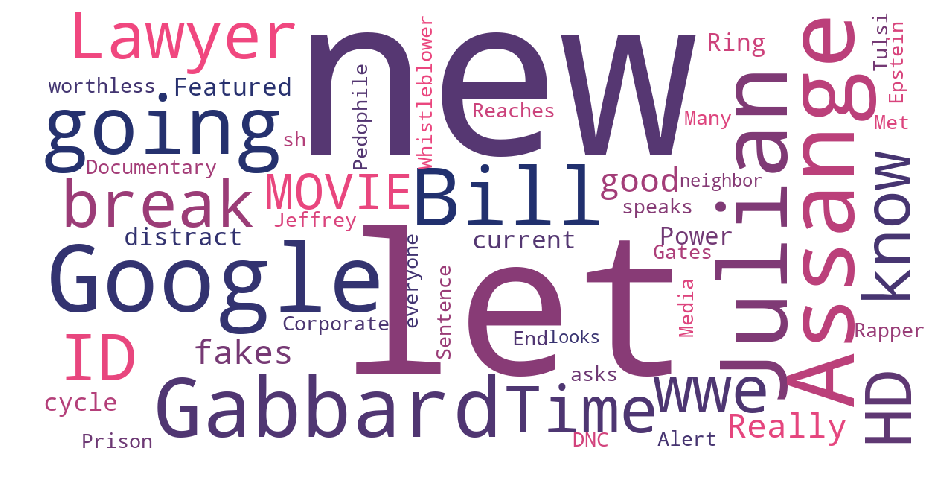

In [24]:
show_wordcloud(df_fake['title'])

In [53]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42, stratify=y)

In [54]:
cv_simple = CountVectorizer(stop_words=stopwords)
X_train_cv = cv_simple.fit_transform(X_train['title'])

cv_train = pd.DataFrame(X_train_cv.todense(), columns=cv_simple.get_feature_names())

In [ ]:
# Function that displays all the features


# def show_all(df):
#     with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
#         display(df)

In [55]:
# Create a data frame of the most common words 

# n_words = 200
words = list(cv_train.sum().sort_values(ascending=False)[:].index)
cv_train['is_fake'] = y_train.values
cv_train_small = cv_train.groupby('is_fake').sum()[words]
cv_train_small.T

is_fake,0,1
news,48,349
trump,199,181
syria,171,17
us,123,61
china,114,54
turkey,110,16
hong,105,17
new,43,78
kong,103,16
will,63,55


In [56]:
tv_simple = TfidfVectorizer(stop_words=stopwords)
X_train_tv = tv_simple.fit_transform(X_train['title'])

tv_train = pd.DataFrame(X_train_tv.todense(), columns=tv_simple.get_feature_names())

In [57]:
# Create a data frame of the most common words 

# n_words = 20
words = list(tv_train.sum().sort_values(ascending=False)[:].index)
tv_train['is_fake'] = y_train.values
tv_train_small = tv_train.groupby('is_fake').sum()[words]
tv_train_small.T

is_fake,0,1
news,6.874278,73.114293
trump,33.258126,33.892272
syria,35.190509,3.251678
china,23.189821,11.469487
us,23.901759,10.577328
turkey,24.987256,3.590148
hong,24.291033,3.708781
kong,23.852745,3.429153
new,7.970875,16.828793
will,12.284902,11.980058


In [58]:
# Basic CountVectorizer and LogisticRegression to get a simple first model

cv_simple = CountVectorizer(stop_words=stopwords)
X_train_cv = cv_simple.fit_transform(X_train['title'])
X_test_cv = cv_simple.transform(X_test['title'])

print("There are {} features in the model.".format(len(cv_simple.get_feature_names())))

lr_simple = LogisticRegressionCV(cv=10)
lr_simple.fit(X_train_cv, y_train)
score_train = lr_simple.score(X_train_cv, y_train)
score_test = lr_simple.score(X_test_cv, y_test)

# There are 3440 features in the model.
# Train score: 0.9695740365111561 Test score 0.8157894736842105
print("Train score: {} Test score {}".format(score_train, score_test))

There are 8925 features in the model.
Train score: 0.9899656720359123 Test score 0.7814726840855107


In [59]:
# What are the words that best predict the target based on the coefficients

coef_names = cv_simple.get_feature_names()

coef_df = pd.DataFrame ({
    'coefs' : coef_names,
    'vals' : lr_simple.coef_[0]
}).set_index('coefs')

coef_df.reindex(coef_df['vals'].abs().sort_values(ascending=False).index)

,vals
coefs,
impeachment,-2.798640e+00
news,2.671723e+00
ecuador,-2.253751e+00
ukraine,-2.147259e+00
saudi,-2.107843e+00
syrian,-2.033280e+00
leave,-1.960133e+00
year,-1.930898e+00
conspiracy,1.930830e+00


In [60]:
cv_gram = CountVectorizer(ngram_range=(1,2))
X_train_cvg = cv_gram.fit_transform(X_train['title'])
X_test_cvg = cv_gram.transform(X_test['title'])

print("There are {} features in the model.".format(len(cv_gram.get_feature_names())))

lr_simple = LogisticRegressionCV(cv=10)
lr_simple.fit(X_train_cvg, y_train)
score_train = lr_simple.score(X_train_cvg, y_train)
score_test = lr_simple.score(X_test_cvg, y_test)

# There are 11975 features in the model.
# Train score: 0.9959432048681541 Test score 0.8218623481781376
print("Train score: {} Test score {}".format(score_train, score_test))

There are 41955 features in the model.
Train score: 0.9970953261156589 Test score 0.8099762470308789


In [ ]:
# print("The baseline accuracy for this model is {:.2f}%.".format(
#     cross_val_score(lr_simple, X_train_cvg, y_train).mean()*100))

In [ ]:
# Run a CountVectorizer and regression adding in a pipeline and grid search. Also, eliminate the stop words.

In [64]:
# Create the pipeline
pipe_cv = Pipeline([
    ('cv', CountVectorizer(stop_words=stopwords)),
    ('lr', LogisticRegression()),
])

params_grid_cv = {
    'cv__ngram_range' : [(1,1), (1,2)],
    'cv__max_df' : [1.0, 0.95],
    'cv__min_df' : [1, 2],
    'cv__max_features' : [2000, 2250, 2500],
    'lr__C' : [1, .05],
    'lr__penalty' : ['l1', 'l2']
}

# Grid Search!
gs_cv = GridSearchCV(pipe_cv, param_grid=params_grid_cv, verbose=1)

gs_cv.fit(X_train['title'], y_train)
score_train = gs_cv.best_score_
score_test = gs_cv.score(X_test['title'], y_test)
params_train = gs_cv.best_params_

for k in params_grid_cv:
    print("{}: {}".format(k,params_train[k]))

print("Train score: {} Test score {}".format(score_train, score_test))

# Fitting 3 folds for each of 192 candidates, totalling 576 fits
# cv__stop_words: english
# cv__ngram_range: (1, 2)
# cv__max_df: 1.0
# cv__min_df: 1
# cv__max_features: 2250
# lr__C: 1
# lr__penalty: l2
# Train score: 0.8079783637592968 Test score 0.8178137651821862

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


cv__ngram_range: (1, 1)
cv__max_df: 1.0
cv__min_df: 1
cv__max_features: 2500
lr__C: 1
lr__penalty: l2
Train score: 0.7773963559545815 Test score 0.7711797307996833


[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:   36.2s finished


In [ ]:
# Take a look at the coefficients in the model to see which words best predict the target

In [65]:
# What are the words that best predict the target?

coef_names = gs_cv.best_estimator_.named_steps['cv'].get_feature_names()
coef_vals = gs_cv.best_estimator_.named_steps['lr'].coef_[0]

coef_df = pd.DataFrame ({
    'coefs' : coef_names,
    'vals' : coef_vals
}).set_index('coefs')

coef_df.reindex(coef_df['vals'].abs().sort_values(ascending=False).index)[:]

,vals
coefs,
impeachment,-2.184504
news,2.072932
ecuador,-1.754262
year,-1.702479
climate,-1.563511
ukraine,-1.560684
rally,-1.528871
saudi,-1.515499
watch,-1.501968


In [ ]:
# Create a function to run grid search on anything we might want to investigate.
# This could be generalized further, I'm sure, but for now it is enough.

In [66]:
def create_pipline(items, use_params, X_train, X_test, y_train, y_test):

    # Add a pipe, add a param !
    pipe_items = {
        'cv': CountVectorizer(stop_words = stopwords),
        'tv': TfidfVectorizer(stop_words = stopwords),
        'hv': HashingVectorizer(stop_words = stopwords),

        'ss' : StandardScaler(),
        'pf' : PolynomialFeatures(),

        'lr' : LogisticRegression(),
        'bnb' : BernoulliNB(),
        'mnb' : MultinomialNB(),
        'rf' : RandomForestClassifier(),
        'gb' : GradientBoostingClassifier(),
        'ab' : AdaBoostClassifier(),
        'svc' : SVC(),
        'knn' : KNeighborsClassifier()
    }

    # Include at least one param for each pipe item
    param_items = {
        'cv' : {
            'cv__ngram_range' : [(1,1), (1,2)],
            'cv__max_df' : [1.0, 0.95],
            'cv__min_df' : [1],
            'cv__max_features' : [2000, 2250, 2500, 2750]
        },
        'tv' : {
            'tv__ngram_range' : [(1,1), (1,2)],
            'tv__max_df' : [1.0, 0.95],
            'tv__min_df' : [1, 2],
            'tv__max_features' : [2000, 2250, 2500, 2750]
        },
        'hv' : {
            'hv__ngram_range' : [(1,1), (1,2)]
        },
        'ss' : {
            'ss__with_mean' : [False]
        },
        'pf' : {
            'pf__degree' : [2]
        },
        'lr' : {
            'lr__C' : [1, .05],
            'lr__penalty' : ['l2']
        },
        'bnb' : {
            'bnb__alpha' : [1.0, 1.5, 1.8, 2.0]
        },
        'mnb' : {
            'mnb__alpha' : [0.8, 1.0, 1.2]
        },
        'rf' : {
            'rf__n_estimators' : [8, 10, 15]
        },
        'gb' : {
            'gb__n_estimators' : [80, 100, 120]
        },
        'ab' : {
            'ab__n_estimators' : [75, 50, 125]
        },
        'svc' : {
            'svc__kernel' : ['linear','poly']
        },
        'knn' : {
            'knn__n_neighbors' : [25,35,45]
        }
    }

    # Create the parameters for GridSearch
    params = dict()
    if use_params:
        for i in items:
            for p in param_items[i]:
                params[p] = param_items[i][p]

    # Create the pipeline
    pipe_list = [(i,pipe_items[i]) for i in items]
    print("Using:")
    for p in pipe_list:
        print("\t" + str(p[1]).split('(')[0])
    pipe = Pipeline(pipe_list)

    # Grid search
    gs = GridSearchCV(pipe, param_grid=params, verbose=1)
    gs.fit(X_train, y_train)

    # Print the results
    train_params = gs.best_params_
    train_score = gs.best_score_
    y_test_hat = gs.predict(X_test)
    test_score = gs.score(X_test, y_test)

    for k in train_params:
        print("{}: {}".format(k,train_params[k]))

    print("Train score: {} Test score {}".format(train_score, test_score))
    print("")

    return train_score, test_score, y_test_hat, train_params


In [ ]:
# Choose some vectorizers and models to test.
# This runs a long time!
# TI ran this many times, updating the parameters to tune

In [67]:
#Decide what to put into the pipline, grid searh, and save the "best" for each grid search
use_params = True
vects = ['cv','tv','hv']
models = ['lr','bnb', 'mnb','rf','gb','ab','svc','knn']
other = ['pf','ss']

# After some initial tests, these seem like the best to pursue further
vects = ['cv','tv']
models = ['lr','bnb', 'mnb']
other = []

model_solns = {}
idx = 0
for v in vects:
    for i in range(len(other)+1):
        for o in list(combinations(other, i)):
            for m in models:
                idx += 1
                pipe_items = [v]
                pipe_items.extend(list(o))
                pipe_items.append(m)
                [train_score, test_score, y_test_hat, best_params] = create_pipline(pipe_items, use_params,
                                                                        X_train['title'], X_test['title'],
                                                                        y_train, y_test)
                model_solns[idx] = {'vectorizer' : v, 'model': m, 'features': list(o),
                                    'train_score': train_score, 'test_score': test_score,
                                    'best_params': best_params, 'y_test_hat' : y_test_hat}


Using:
	CountVectorizer
	LogisticRegression
Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   12.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


cv__max_df: 1.0
cv__max_features: 2750
cv__min_df: 1
cv__ngram_range: (1, 1)
lr__C: 1
lr__penalty: l2
Train score: 0.7776604172167942 Test score 0.7735550277117973

Using:
	CountVectorizer
	BernoulliNB
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:   22.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


bnb__alpha: 1.0
cv__max_df: 1.0
cv__max_features: 2250
cv__min_df: 1
cv__ngram_range: (1, 1)
Train score: 0.7837338262476895 Test score 0.7878068091844814

Using:
	CountVectorizer
	MultinomialNB
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:   17.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


cv__max_df: 1.0
cv__max_features: 2250
cv__min_df: 1
cv__ngram_range: (1, 1)
mnb__alpha: 1.2
Train score: 0.8001056245048851 Test score 0.7957244655581948

Using:
	TfidfVectorizer
	LogisticRegression
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:   23.5s finished


lr__C: 1
lr__penalty: l2
tv__max_df: 1.0
tv__max_features: 2750
tv__min_df: 2
tv__ngram_range: (1, 2)
Train score: 0.7839978875099023 Test score 0.7901821060965954

Using:
	TfidfVectorizer
	BernoulliNB
Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 384 out of 384 | elapsed:   46.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


bnb__alpha: 1.0
tv__max_df: 1.0
tv__max_features: 2250
tv__min_df: 1
tv__ngram_range: (1, 1)
Train score: 0.7837338262476895 Test score 0.7878068091844814

Using:
	TfidfVectorizer
	MultinomialNB
Fitting 3 folds for each of 96 candidates, totalling 288 fits
mnb__alpha: 0.8
tv__max_df: 1.0
tv__max_features: 2750
tv__min_df: 2
tv__ngram_range: (1, 1)
Train score: 0.7985212569316081 Test score 0.7885985748218527



[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:   34.7s finished


In [ ]:
# Lots of results to examine. Unfortunately, none are exactly great. This is unsurprising given the two subreddits that I chose

In [ ]:
# V. Evaluate the model

In [ ]:
# Examine the best solutions from each call to the grid search

In [68]:
df_solns = pd.DataFrame(model_solns)
df_solns.sort_values(ascending=False, by='test_score',axis=1)

,3,4,6,2,5,1
best_params,"{'cv__max_df': 1.0, 'cv__max_features': 2250, ...","{'lr__C': 1, 'lr__penalty': 'l2', 'tv__max_df'...","{'mnb__alpha': 0.8, 'tv__max_df': 1.0, 'tv__ma...","{'bnb__alpha': 1.0, 'cv__max_df': 1.0, 'cv__ma...","{'bnb__alpha': 1.0, 'tv__max_df': 1.0, 'tv__ma...","{'cv__max_df': 1.0, 'cv__max_features': 2750, ..."
features,[],[],[],[],[],[]
model,mnb,lr,mnb,bnb,bnb,lr
test_score,0.795724,0.790182,0.788599,0.787807,0.787807,0.773555
train_score,0.800106,0.783998,0.798521,0.783734,0.783734,0.77766
vectorizer,cv,tv,tv,cv,tv,cv
y_test_hat,"[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, ...","[0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, ...","[0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","[0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","[0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."


In [69]:
df_solns.loc[['vectorizer','model','train_score','test_score','best_params'],:]

,1,2,3,4,5,6
vectorizer,cv,cv,cv,tv,tv,tv
model,lr,bnb,mnb,lr,bnb,mnb
train_score,0.77766,0.783734,0.800106,0.783998,0.783734,0.798521
test_score,0.773555,0.787807,0.795724,0.790182,0.787807,0.788599
best_params,"{'cv__max_df': 1.0, 'cv__max_features': 2750, ...","{'bnb__alpha': 1.0, 'cv__max_df': 1.0, 'cv__ma...","{'cv__max_df': 1.0, 'cv__max_features': 2250, ...","{'lr__C': 1, 'lr__penalty': 'l2', 'tv__max_df'...","{'bnb__alpha': 1.0, 'tv__max_df': 1.0, 'tv__ma...","{'mnb__alpha': 0.8, 'tv__max_df': 1.0, 'tv__ma..."


In [ ]:
# Closely look at the parameters and see if we hit an boundary on our parameter options

In [70]:
df_solns.loc[:,3]

best_params    {'cv__max_df': 1.0, 'cv__max_features': 2250, ...
features                                                      []
model                                                        mnb
test_score                                              0.795724
train_score                                             0.800106
vectorizer                                                    cv
y_test_hat     [0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, ...
Name: 3, dtype: object

In [71]:
# Let's look at the parameters of one solution
df_solns.loc['best_params',3]

{'cv__max_df': 1.0,
 'cv__max_features': 2250,
 'cv__min_df': 1,
 'cv__ngram_range': (1, 1),
 'mnb__alpha': 1.2}

In [ ]:
# Can get a better value by averaging our top models?

In [72]:
# Average the y_test_hat vectors to see if we can improve the score
y_test_hat_agg = sum(df_solns.loc['y_test_hat',:])
y_test_hat = np.round(y_test_hat_agg/df_solns.shape[1])
print("The accuracy score of the average test solutions is {:.2f}%.".format(accuracy_score(y_test,y_test_hat)*100))

The accuracy score of the average test solutions is 80.13%.


In [ ]:
# This aggregated solution is actually a little better

In [ ]:
# What are some of the "misses"?

In [73]:
# Not sure why I get warnings when adding these
X_test['y'] = y_test.values
X_test['y_hat'] = y_test_hat
X_test['y_hat_agg'] = y_test_hat_agg

In [ ]:
# Remember, where y=1, the post is from r/CapeCod

In [74]:
X_test_incorrect = X_test[X_test["y"] != X_test['y_hat']]
X_test_incorrect.head(20)

,title,y,y_hat,y_hat_agg
id,,,,
dgbpij,Pro-Vaccine Internet Trolls May be Trained Gov...,1,0.0,0
dgmleo,Trump Administration Provides New Evidence for...,0,1.0,6
bk5tl5,Farming our Way to a Better Planet Requires In...,0,1.0,4
dgta6z,Chinese Facial Recognition Will Monitor Mobile...,0,1.0,6
dg52oh,"Padres’ Jacob Nix tased, charged with criminal...",0,1.0,4
dh37bi,I am Russia . Ask questions,0,1.0,6
dggizb,Incoming call:::::,0,1.0,4
dg15nl,"What does ""Free Hong Kong"" mean?",1,0.0,0
a0uvob,Testing my night vision security cam..,1,0.0,2


In [ ]:
# With more data, I think some of these could be mode accurately predicted. For example:

# "Marstons Mills" is a town on Cape Cod.
# Fertitta is a chef in Galveston.
# But some are generic and likely could never be determined:
# Dog friendly restaurants?
# Batting cages???

In [75]:
cv_simple = CountVectorizer(stop_words=stopwords)
X_test_cv = cv_simple.fit_transform(X_test_incorrect['title'])
cv_test = pd.DataFrame(X_test_cv.todense(), columns=cv_simple.get_feature_names())

In [76]:
# Create a data frame of the most common words 
# n_words = 40
words = list(cv_test.sum().sort_values(ascending=False)[:].index)
print(words)

cv_test['is_fake_test'] = X_test_incorrect['y'].values
cv_test_small = cv_test.groupby('is_fake_test').sum()[words]

['trump', 'us', 'will', 'china', 'new', 'israel', 'ukraine', 'news', 'government', 'says', 'war', 'time', 'kong', 'don', 'president', 'cnn', 'fox', 'usa', 'people', 'uk', 'state', 'iraq', 'hong', 'children', 'history', 'coup', 'fire', 'evidence', '2019', 'saudi', 'biden', 'found', 'world', 'american', 'iran', 'video', 'face', 'let', 'attack', 'trying', 'money', 'life', 'everyone', 'one', 'made', 'donald', 'ellen', 'going', 'breaking', 'degeneres', 'syria', 'bush', 'stop', 'internet', 'chinese', 'better', 'joe', 'climate', 'white', 'russia', 'deep', 'place', 'oligarchs', 'obama', 'church', 'policy', 'billion', 'think', 'nothing', 'change', 'potential', 'call', 'turns', 'california', 'attacks', 'never', 'something', 'spread', 'best', 'pg', 'americans', 'control', 'corruption', 'congress', 'police', 'community', 'ask', 'arabia', 'east', 'come', 'end', 'take', 'democrats', 'dead', 'another', 'russian', 'power', 'rally', 'officials', 'make', 'media', 'may', 'many', 'wrong', 'isis', '2020', 

In [77]:
columns = [c for c in cv_test_small.columns if c in cv_train.columns]
cv_train = cv_train[columns]
cv_train['is_fake'] = y_train.values
cv_train_small = cv_train.groupby('is_fake').sum()

columns = [c for c in cv_train.columns if c in cv_test_small.columns]
cv_test_small = cv_test_small[columns]

cv_merge = pd.concat([cv_train_small, cv_test_small],keys=['train', 'incorrect'], sort=True)
cv_merge.head()


09  10  100  11  13  150  18  1993  2010  2011  ...  wtc  \
          is_fake                                                  ...        
train     0         0  23    9   5   3    0   4     0     0     0  ...    0   
          1         1  18    7  15   2    3   7     1     1     1  ...    1   
incorrect 0         1   1    2   1   0    0   1     1     1     0  ...    1   
          1         0   0    0   0   1    1   0     0     0     1  ...    0   

                   wtf  yacht  yeah  year  years  yellow  yo  zionist  \
          is_fake                                                       
train     0          1      1     0    28     25       1   0        0   
          1          2      0     3     6     28       0   2        4   
incorrect 0          0      1     1     0      1       0   1        1   
          1          1      0     0     1      1       1   0        0   

                   zuckerberg  
          is_fake              
train     0                 0  
          1                 3  
incorrect 0                 1  
          1                 0  

[4 rows x 1145 columns]

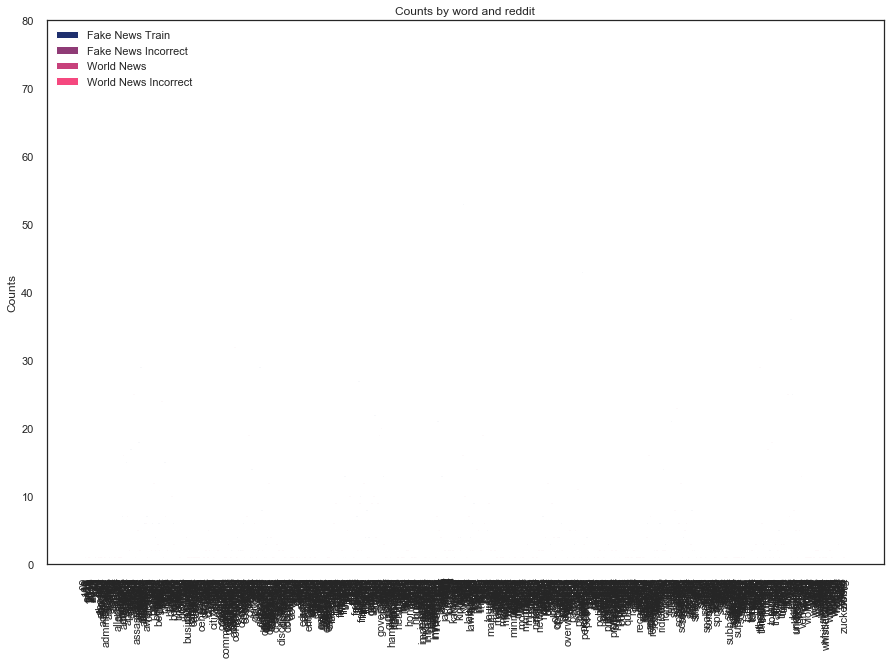

In [79]:
# Adapted from https://matplotlib.org/examples/api/barchart_demo.html

words = cv_merge.columns
n_words = len(words)
words_count_fake_train = cv_merge.loc["train"].loc[0]
words_count_news_train = cv_merge.loc["train"].loc[1]
words_count_fake_wrong = cv_merge.loc["incorrect"].loc[0]
words_count_news_wrong = cv_merge.loc["incorrect"].loc[1]

width = 0.25       # the width of the bars
ind = np.arange(n_words)

fig, ax = plt.subplots(figsize=(15, 10))
rects0 = ax.bar(ind,         words_count_fake_train, width, color=theme[0])
rects1 = ax.bar(ind+width,   words_count_fake_wrong, width, color=theme[2])
rects2 = ax.bar(ind+2*width, words_count_news_train, width, color=theme[3])
rects3 = ax.bar(ind+3*width, words_count_news_wrong, width, color=theme[-1])

# add some text for labels, title and axes ticks
ax.set_ylabel('Counts')
ax.set_title('Counts by word and reddit')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(words,rotation='vertical')

ax.set_ylim(0,80)

ax.legend((rects0, rects1, rects2, rects3), ('Fake News Train', 'Fake News Incorrect',
                                                         'World News', 'World News Incorrect'));


In [ ]:
# This plot did not come out as well as I had hoped, but I think I can improve on it in the future

In [ ]:
# VI. Executive summary
# The data
# For this project, I chose two sub-reddits to compare, r/Cape Cod and r/galveston. As this was my first experience with Reddit, I had some challenege to come up with two forums to compare since most anything I chose did not have enough posts. With more experience with Reddit, I might have been able to chose more interesting topics to compare. Scraping was easy enough, but since the Reddits are not extremely active, I did not end up with as much data as I would have liked

# Exploring the data
# Once I had scraped the data, I ran a number of initial tests on it to get some insight. I used a word cloud to illustrate the word used most often in each subreddit. I then ran a vectorizer on unigrams and made some bar charts comparing the usage of the most words. The results were not particularly surprising, though there were some words I had not anticipated such as 'seawall' and 'gaming'.

# Modeling the problem
# From there, I dove into NLP. I ran a few simple tests, determined a baseline accuracy, and examined the coefficients determied by logistical regression. Again, the words with the most influence were not surprising - mostly place names or things unique to one place or the other. Actually, there was one word with a aurprisingly high coefficient - 'water'.

# Evaluate the model
# I then spent some time trying to generalize pipelines in order to efficiently run lots of different grid searches on many different models and parameters. This generalized function has room for improvement, but was quite helpful for me to stay organized in my tests. I saved the "best" from each test and turned the data into a dataframe in order to explore the incorrect predictions.

# Despite tuning the parameters, I could not get better than 83% accuracy, unfortunately.